In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

# основная часть

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/merge_preprocessing_dano/files/final_accidents_data.xlsx')
df.head(5)

,coordL,coordW,place,district,DTPType,date,real_date,month,season,NVehicles,NPatricipants,NInjured,NFatal,additionalFactor,lightConditions,weatherConditions,placeConditions,closeObjects,violations,violationsAdditional,privod,traffic_regime,pokritie,neispravnosti,safety_belt,sublocality
0,37.464817,55.758116,ул Мнёвники Нижн.,Хорошево-мневники,Наезд на препятствие,01.01.2020,2020-01-01,1,Winter,1,1,1,0,Сведения отсутствуют,0.5,Пасмурно,Перегон (нет объектов на месте ДТП),Остановка общественного транспорта,Несоответствие скорости конкретным условиям дв...,Нет нарушений,передний,Режим движения не изменялся,Мокрое,Технические неисправности отсутствуют,Нет,Северо-Западный административный округ
1,37.388953,55.811338,Московская кольцевая автомобильная дорога (МКА...,Строгино,Наезд на стоящее ТС,01.01.2020,2020-01-01,1,Winter,2,2,1,0,"Наличие на дороге объектов, мешающих движению",1.0,Ясно,Перегон (нет объектов на месте ДТП),Отсутствие в непосредственной близости объекто...,Несоответствие скорости конкретным условиям дв...,Нет нарушений,передний,Движение частично перекрыто,Сухое,Технические неисправности отсутствуют,Нет,Северо-Западный административный округ
2,37.623153,55.866787,Юрловский пр-д,Отрадное,Наезд на пешехода,01.01.2020,2020-01-01,1,Winter,1,2,1,0,Сужение проезжей части,1.0,Пасмурно,Внутридворовая территория,Административные здания,Несоблюдение очередности проезда,Другие нарушения ПДД водителем,праворукий,Режим движения не изменялся,Сухое,Технические неисправности отсутствуют,Нет,Северо-Восточный административный округ
3,37.588413,55.660576,ул Болотниковская,Зюзино,Столкновение,01.01.2020,2020-01-01,1,Winter,2,3,1,0,Сведения отсутствуют,0.5,Пасмурно,Регулируемый пешеходный переход,Остановка общественного транспорта,Несоблюдение очередности проезда,Нет нарушений,передний,Движение частично перекрыто,Мокрое,Технические неисправности отсутствуют,Нет,Юго-Западный административный округ
4,37.636467,55.805098,пр-кт Мира,Алексеевский,Падение чего-либо,01.01.2020,2020-01-01,1,Winter,1,2,1,0,"Участок, контролируемый камерой",0.5,Ясно,Остановка общественного транспорта,Остановка общественного транспорта,Нарушение правил пользования общественным тран...,Нарушение правил перевозки людей,передний,Режим движения не изменялся,Сухое,Технические неисправности отсутствуют,Нет,Северо-Восточный административный округ


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7888 entries, 0 to 7887
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   coordL                7888 non-null   float64       
 1   coordW                7888 non-null   float64       
 2   place                 7888 non-null   object        
 3   district              7888 non-null   object        
 4   DTPType               7888 non-null   object        
 5   date                  7888 non-null   object        
 6   real_date             7888 non-null   datetime64[ns]
 7   month                 7888 non-null   int64         
 8   season                7888 non-null   object        
 9   NVehicles             7888 non-null   int64         
 10  NPatricipants         7888 non-null   int64         
 11  NInjured              7888 non-null   int64         
 12  NFatal                7888 non-null   int64         
 13  additionalFactor  

## все о РИТА

В России существуют множество статей и гостов по определению материального ущерба от ДТП, например, есть структура EMPY для оценки вреда ТС, в которой содержаться статьи:

  * «О единой методике определения размера расходов на восстановительный ремонт в отношении поврежденного транспортного средства» N 432-П.
  * «О правилах проведения независимой технической экспертизы транспортного средства» N 433-П.
  * Электронная база стоимости запчастей.
Всего в документе 7 глав и 10 приложений-справочников. В главах подробно изложен порядок экспертиз после ДТП, процесс установки характера дефектов, описаны алгоритмы расчетов стоимости ремонта. В справочниках изложены:

1. — требования к проведению фотосъемки;
2. ⬇⬇⬇⬇⬇
3. — перечень типовых повреждений и рекомендации производителей по ремонту кузова (иномарки);
4. — цены на запасные части по регионам. Всего определено 13 зон, в каждой из которых действуют свои цены. Например, запчасти в Санкт-Петербурге и Москве значительно дороже, чем в среднем по России;
5. ⬇⬇⬇⬇⬇
6. — коэффициенты износа, дополнительные сведения;
7. — детали, для которых износ не предусмотрен (показатель износа — 0);
8. — данные по среднегодовому пробегу машины по регионам;
9. — коэффициенты эксплуатации;
10. — коэффициенты механических повреждений.

Или так же есть много других статей по поводу возмещения матереального ущерба, например, "Федеральный закон "Об обязательном страховании гражданской ответственности владельцев транспортных средств", но в нашем датсете данных для полной оценки материального ущерба от аварии нет. 
___
Изначально планировалось составить 2 индекса, индекс оценки материального ущерба, и индекс оценки тяжести аварии, но после попыток их создать оказалось, что такие индексы будут сильно влиять друг на друга и нельзя составить индекс материального ущерба, без учета человеческих потерь и травм. Исходя из этого мы решили объединить индексы в один общий индекс ущерба аварии, который назовем Рассчетный Индекс Тяжести Аварии или РИТА.
___
По поводу оценки человеческих потерь в РИТА-е мы опираемся на ОСАГО. Например, возьмем статью 12 п7. Там сказано 

"Размер страховой выплаты за причинение вреда жизни потерпевшего составляет:
475 тысяч рублей - выгодоприобретателям, указанным в пункте 6 настоящей статьи;
не более 25 тысяч рублей в счет возмещения расходов на погребение - лицам, понесшим такие расходы."
___
Для каждого пункта будем подсчитывать примерную стоимость единицы, если такое возможно.

в РИТА-е учтем столбцы:
  * NVehicles (число автомобилей участников) 100000;
  * NPatricipants (число участников) с малым коэф. из-за моральных компенсаций 500;
  * NInjured (число пострадавших) 15000;
  * NFatal (число погибших) 500000;
  * traffic_regime (изменение режима движения в результате ДТП) ;
  * neispravnosti;
  * privod, как еще однин столбец про сами ТС, скажем, что 4 колеса тормозят лучше 2.


Далее зададим коэффициенты этой регрессии.

Коэффициенты регрессии:
  * NVehicles  --  100;
  * NPatricipants  --  0.5;
  * NInjured  --  15;
  * NFatal  --  500;
  * traffic_regime  --  traffic_regime_index;
  * neispravnosti  --  neispravnosti_index;
  * privod  --  privod_index.

### traffic_regime_index

https://yandex.ru/company/researches/2017/moscow_districts

In [ ]:
reiting_yandex = pd.read_csv('/content/drive/MyDrive/merge_preprocessing_dano/files/raiting_yandex.csv', sep=";")
reiting_yandex.head()

,district,little_infra,comfort_for_life,wery_comfort_for_life,not_happy,colture,happynass,culture-happy,place_in_life_infra,place_in_happy,raiting_of_life,raiting_of_happy
0,Академический,4,31,65,16,2,51,31,7,25,91,76
1,Алексеевский,17,57,26,6,3,54,37,72,16,74,85
2,Алтуфьевский,15,45,40,50,0,50,0,55,66,78,42
3,Арбат,0,0,100,0,0,0,100,1,3,100,100
4,Аэропорт,3,32,65,16,0,49,35,5,23,92,76


отсюда нам нужен только рейтинг жизни в районах, используем его как коэффициент

In [ ]:
life_raiting = dict()
for i in range(len(reiting_yandex)):
  life_raiting[reiting_yandex.loc[i, 'district']] = reiting_yandex.loc[i, 'raiting_of_life']
print(life_raiting)

{'Академический': 91, 'Алексеевский': 74, 'Алтуфьевский': 78, 'Арбат': 100, 'Аэропорт': 92, 'Бабушкинский': 80, 'Басманный': 91, 'Беговой': 85, 'Бескудниковский': 79, 'Бибирево': 84, 'Бирюлёво Восточное': 62, 'Бирюлёво Западное': 72, 'Богородское': 79, 'Братеево': 80, 'Бутырский': 87, 'Вешняки': 75, 'Войковский': 58, 'Восточное Дегунино': 67, 'Восточное Измайлово': 85, 'Выхино-Жулебино': 74, 'Гагаринский': 75, 'Головинский': 59, 'Гольяново': 68, 'Даниловский': 36, 'Дмитровский': 67, 'Донской': 55, 'Дорогомилово': 86, 'Замоскворечье': 87, 'Западное Дегунино': 82, 'Зюзино': 78, 'Зябликово': 81, 'Ивановское': 73, 'Измайлово': 82, 'Капотня': 42, 'Коньково': 88, 'Коптево': 80, 'Косино-Ухтомский': 60, 'Котловка': 87, 'Красносельский': 80, 'Крылатское': 79, 'Кузьминки': 77, 'Кунцево': 76, 'Куркино': 46, 'Левобережный': 54, 'Лефортово': 84, 'Лианозово': 85, 'Ломоносовский': 86, 'Лосиноостровский': 73, 'Люблино': 61, 'Марфино': 56, 'Марьина Роща': 93, 'Марьино': 78, 'Метрогородок': 85, 'Мещанск

In [ ]:
def find_reit(district):
  if district in life_raiting:
    return life_raiting[district] / 10
  else:
    return 1


def replace_traf(string, koef_dist):
  if string == 'Режим движения не изменялся':
    return 0
  elif string == 'Движение частично перекрыто':
    return 25 * koef_dist
  else:
    return 300 * koef_dist

df['traffic_regime_index'] = [replace_traf(df.loc[i, 'traffic_regime'], find_reit(df.loc[i, 'district'])) for i in range(len(df))]
df.head()

,coordL,coordW,place,district,DTPType,date,real_date,month,season,NVehicles,NPatricipants,NInjured,NFatal,additionalFactor,lightConditions,weatherConditions,placeConditions,closeObjects,violations,violationsAdditional,privod,traffic_regime,pokritie,neispravnosti,safety_belt,sublocality,traffic_regime_index
0,37.464817,55.758116,ул Мнёвники Нижн.,Хорошево-мневники,Наезд на препятствие,01.01.2020,2020-01-01,1,Winter,1,1,1,0,Сведения отсутствуют,0.5,Пасмурно,Перегон (нет объектов на месте ДТП),Остановка общественного транспорта,Несоответствие скорости конкретным условиям дв...,Нет нарушений,передний,Режим движения не изменялся,Мокрое,Технические неисправности отсутствуют,Нет,Северо-Западный административный округ,0.0
1,37.388953,55.811338,Московская кольцевая автомобильная дорога (МКА...,Строгино,Наезд на стоящее ТС,01.01.2020,2020-01-01,1,Winter,2,2,1,0,"Наличие на дороге объектов, мешающих движению",1.0,Ясно,Перегон (нет объектов на месте ДТП),Отсутствие в непосредственной близости объекто...,Несоответствие скорости конкретным условиям дв...,Нет нарушений,передний,Движение частично перекрыто,Сухое,Технические неисправности отсутствуют,Нет,Северо-Западный административный округ,165.0
2,37.623153,55.866787,Юрловский пр-д,Отрадное,Наезд на пешехода,01.01.2020,2020-01-01,1,Winter,1,2,1,0,Сужение проезжей части,1.0,Пасмурно,Внутридворовая территория,Административные здания,Несоблюдение очередности проезда,Другие нарушения ПДД водителем,праворукий,Режим движения не изменялся,Сухое,Технические неисправности отсутствуют,Нет,Северо-Восточный административный округ,0.0
3,37.588413,55.660576,ул Болотниковская,Зюзино,Столкновение,01.01.2020,2020-01-01,1,Winter,2,3,1,0,Сведения отсутствуют,0.5,Пасмурно,Регулируемый пешеходный переход,Остановка общественного транспорта,Несоблюдение очередности проезда,Нет нарушений,передний,Движение частично перекрыто,Мокрое,Технические неисправности отсутствуют,Нет,Юго-Западный административный округ,195.0
4,37.636467,55.805098,пр-кт Мира,Алексеевский,Падение чего-либо,01.01.2020,2020-01-01,1,Winter,1,2,1,0,"Участок, контролируемый камерой",0.5,Ясно,Остановка общественного транспорта,Остановка общественного транспорта,Нарушение правил пользования общественным тран...,Нарушение правил перевозки людей,передний,Режим движения не изменялся,Сухое,Технические неисправности отсутствуют,Нет,Северо-Восточный административный округ,0.0


### neispravnosti_index

In [ ]:
df.neispravnosti.value_counts()

Технические неисправности отсутствуют    7554
Имеются неисправности                     334
Name: neispravnosti, dtype: int64

In [ ]:
def replace_neis(string):
  if string == 'Технические неисправности отсутствуют':
    return 0
  else:
    return 15

df['neispravnosti_index'] = [replace_neis(i) for i in df['neispravnosti']]
df.head()

,coordL,coordW,place,district,DTPType,date,real_date,month,season,NVehicles,NPatricipants,NInjured,NFatal,additionalFactor,lightConditions,weatherConditions,placeConditions,closeObjects,violations,violationsAdditional,privod,traffic_regime,pokritie,neispravnosti,safety_belt,sublocality,traffic_regime_index,neispravnosti_index
0,37.464817,55.758116,ул Мнёвники Нижн.,Хорошево-мневники,Наезд на препятствие,01.01.2020,2020-01-01,1,Winter,1,1,1,0,Сведения отсутствуют,0.5,Пасмурно,Перегон (нет объектов на месте ДТП),Остановка общественного транспорта,Несоответствие скорости конкретным условиям дв...,Нет нарушений,передний,Режим движения не изменялся,Мокрое,Технические неисправности отсутствуют,Нет,Северо-Западный административный округ,0.0,0
1,37.388953,55.811338,Московская кольцевая автомобильная дорога (МКА...,Строгино,Наезд на стоящее ТС,01.01.2020,2020-01-01,1,Winter,2,2,1,0,"Наличие на дороге объектов, мешающих движению",1.0,Ясно,Перегон (нет объектов на месте ДТП),Отсутствие в непосредственной близости объекто...,Несоответствие скорости конкретным условиям дв...,Нет нарушений,передний,Движение частично перекрыто,Сухое,Технические неисправности отсутствуют,Нет,Северо-Западный административный округ,165.0,0
2,37.623153,55.866787,Юрловский пр-д,Отрадное,Наезд на пешехода,01.01.2020,2020-01-01,1,Winter,1,2,1,0,Сужение проезжей части,1.0,Пасмурно,Внутридворовая территория,Административные здания,Несоблюдение очередности проезда,Другие нарушения ПДД водителем,праворукий,Режим движения не изменялся,Сухое,Технические неисправности отсутствуют,Нет,Северо-Восточный административный округ,0.0,0
3,37.588413,55.660576,ул Болотниковская,Зюзино,Столкновение,01.01.2020,2020-01-01,1,Winter,2,3,1,0,Сведения отсутствуют,0.5,Пасмурно,Регулируемый пешеходный переход,Остановка общественного транспорта,Несоблюдение очередности проезда,Нет нарушений,передний,Движение частично перекрыто,Мокрое,Технические неисправности отсутствуют,Нет,Юго-Западный административный округ,195.0,0
4,37.636467,55.805098,пр-кт Мира,Алексеевский,Падение чего-либо,01.01.2020,2020-01-01,1,Winter,1,2,1,0,"Участок, контролируемый камерой",0.5,Ясно,Остановка общественного транспорта,Остановка общественного транспорта,Нарушение правил пользования общественным тран...,Нарушение правил перевозки людей,передний,Режим движения не изменялся,Сухое,Технические неисправности отсутствуют,Нет,Северо-Восточный административный округ,0.0,0


In [ ]:
df.neispravnosti_index.value_counts()

0     7554
15     334
Name: neispravnosti_index, dtype: int64

### privod_index

In [ ]:
df.privod.value_counts()

передний                             3913
задний,передний                       733
полный,передний                       706
задний                                652
передний,праворукий                   579
полный                                513
праворукий                            302
полный,праворукий                     120
полный,задний                          91
задний,праворукий                      79
полный,задний,передний                 61
Нет информации                         60
полный,передний,праворукий             42
задний,передний,праворукий             29
полный,задний,передний,праворукий       5
полный,задний,праворукий                3
Name: privod, dtype: int64

In [ ]:
def replace_privod(string):
  index = 0
  if 'полный' in string:
    index += -5
  if 'задний' in string:
    index += 5
  if 'передний' in string:
    index += 10
  if 'праворукий' in string:
    index += 15
  return index

df['privod_index'] = [replace_privod(i) for i in df['privod']]
df.head()

,coordL,coordW,place,district,DTPType,date,real_date,month,season,NVehicles,NPatricipants,NInjured,NFatal,additionalFactor,lightConditions,weatherConditions,placeConditions,closeObjects,violations,violationsAdditional,privod,traffic_regime,pokritie,neispravnosti,safety_belt,sublocality,traffic_regime_index,neispravnosti_index,privod_index
0,37.464817,55.758116,ул Мнёвники Нижн.,Хорошево-мневники,Наезд на препятствие,01.01.2020,2020-01-01,1,Winter,1,1,1,0,Сведения отсутствуют,0.5,Пасмурно,Перегон (нет объектов на месте ДТП),Остановка общественного транспорта,Несоответствие скорости конкретным условиям дв...,Нет нарушений,передний,Режим движения не изменялся,Мокрое,Технические неисправности отсутствуют,Нет,Северо-Западный административный округ,0.0,0,10
1,37.388953,55.811338,Московская кольцевая автомобильная дорога (МКА...,Строгино,Наезд на стоящее ТС,01.01.2020,2020-01-01,1,Winter,2,2,1,0,"Наличие на дороге объектов, мешающих движению",1.0,Ясно,Перегон (нет объектов на месте ДТП),Отсутствие в непосредственной близости объекто...,Несоответствие скорости конкретным условиям дв...,Нет нарушений,передний,Движение частично перекрыто,Сухое,Технические неисправности отсутствуют,Нет,Северо-Западный административный округ,165.0,0,10
2,37.623153,55.866787,Юрловский пр-д,Отрадное,Наезд на пешехода,01.01.2020,2020-01-01,1,Winter,1,2,1,0,Сужение проезжей части,1.0,Пасмурно,Внутридворовая территория,Административные здания,Несоблюдение очередности проезда,Другие нарушения ПДД водителем,праворукий,Режим движения не изменялся,Сухое,Технические неисправности отсутствуют,Нет,Северо-Восточный административный округ,0.0,0,15
3,37.588413,55.660576,ул Болотниковская,Зюзино,Столкновение,01.01.2020,2020-01-01,1,Winter,2,3,1,0,Сведения отсутствуют,0.5,Пасмурно,Регулируемый пешеходный переход,Остановка общественного транспорта,Несоблюдение очередности проезда,Нет нарушений,передний,Движение частично перекрыто,Мокрое,Технические неисправности отсутствуют,Нет,Юго-Западный административный округ,195.0,0,10
4,37.636467,55.805098,пр-кт Мира,Алексеевский,Падение чего-либо,01.01.2020,2020-01-01,1,Winter,1,2,1,0,"Участок, контролируемый камерой",0.5,Ясно,Остановка общественного транспорта,Остановка общественного транспорта,Нарушение правил пользования общественным тран...,Нарушение правил перевозки людей,передний,Режим движения не изменялся,Сухое,Технические неисправности отсутствуют,Нет,Северо-Восточный административный округ,0.0,0,10


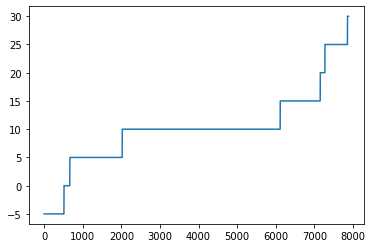

In [ ]:
from copy import deepcopy
df1 = deepcopy(df)
plt.plot(range(7888), df1.sort_values(by='privod_index')['privod_index'].values)
plt.show()

## рассчет РИТА-а

добавить в риту коэффициент инфляции и стоимости по районам

In [ ]:
def for_rita(NVehicles, NPatricipants, NInjured, NFatal, traffic_regime_index, neispravnosti_index, privod_index):
  return NPatricipants * 0.5 + NInjured * 15 + NFatal * 500 + traffic_regime_index + neispravnosti_index + privod_index + NVehicles * 100

In [ ]:
df.loc[6974, 'privod_index']

10

In [ ]:
df['RITA'] = [for_rita(df.loc[i, 'NVehicles'], df.loc[i, 'NPatricipants'], df.loc[i, 'NInjured'], df.loc[i, 'NFatal'], df.loc[i, 'traffic_regime_index'], df.loc[i, 'neispravnosti_index'], df.loc[i, 'privod_index']) for i in range(len(df))]

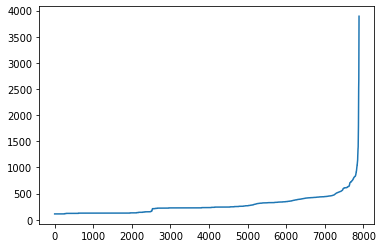

In [ ]:
plt.plot(range(7888), df.sort_values(by='RITA')['RITA'].values)

In [ ]:
df['FAIL'] = [df.loc[i, 'NPatricipants'] +  df.loc[i, 'NInjured'] * 1.5 +  df.loc[i, 'NFatal'] * 500 for i in range(len(df))]

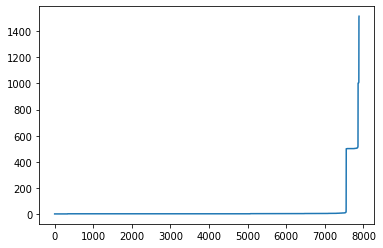

In [ ]:
plt.plot(range(7888), df.sort_values(by='FAIL')['FAIL'].values)

In [ ]:
df.groupby('violations').agg({'RITA':'mean', 'FAIL': 'mean'})

,RITA,FAIL
violations,,
Выезд на полосу встречного движения,419.367424,81.178030
"Выезд на полосу встречного движения в местах, где это запрещено",370.916667,4.916667
"Выезд на полосу встречного движения с разворотом, поворотом налево или объездом препятствия",298.333333,3.722222
Движение во встречном направлении по дороге с односторонним движением,289.750000,3.500000
Другие нарушения ПДД водителем,205.047619,39.142857
Другие нарушения ПДД водителями (не применяется с 12.2020),173.333333,3.166667
Иные нарушения,421.250000,254.000000
Нарушение правил буксировки,332.000000,5.500000
Нарушение правил обгона,388.500000,3.500000


In [ ]:
df.to_excel('accidents_with_RITA.xlsx')

## продолжение 

In [ ]:
df = df.sort_values(by='RITA')
df.head()

,coordL,coordW,place,district,DTPType,date,real_date,month,season,NVehicles,NPatricipants,NInjured,NFatal,additionalFactor,lightConditions,weatherConditions,placeConditions,closeObjects,violations,violationsAdditional,privod,traffic_regime,pokritie,neispravnosti,safety_belt,sublocality,traffic_regime_index,neispravnosti_index,privod_index,RITA,FAIL
716,37.316040,55.476567,Калужское ш.,Троицк,Наезд на препятствие,29.01.2020,2020-01-29,1,Winter,1,1,1,0,Сведения отсутствуют,1.0,Пасмурно,Перегон (нет объектов на месте ДТП),АЗС,Нарушение правил расположения ТС на проезжей ч...,Нет нарушений,полный,Режим движения не изменялся,Мокрое,Технические неисправности отсутствуют,Нет,Троицкий Адм. округ,0.0,0,-5,110.5,2.5
1046,37.288510,55.591903,M3,"Филимонковское, Поселение",Наезд на препятствие,11.02.2020,2020-11-02,11,Autumn,1,1,1,0,Сведения отсутствуют,1.0,Снегопад(туман),Перегон (нет объектов на месте ДТП),"Аэропорт, ж/д вокзал (ж/д станция), речной или...",Несоответствие скорости конкретным условиям дв...,Нет нарушений,полный,Режим движения не изменялся,Снег и/или лёд,Технические неисправности отсутствуют,Нет,Новомосковский Адм. округ,0.0,0,-5,110.5,2.5
2327,37.585140,55.792759,ул Бутырская,Савеловский,Наезд на препятствие,19.04.2020,2020-04-19,4,Spring,1,1,1,0,Сведения отсутствуют,0.5,Пасмурно,"Мост, эстакада, путепровод",АЗС,Несоответствие скорости конкретным условиям дв...,Нет нарушений,полный,Режим движения не изменялся,Мокрое,Технические неисправности отсутствуют,Нет,Северный административный округ,0.0,0,-5,110.5,2.5
6522,37.704724,55.642458,ул Донецкая,Марьино,Наезд на препятствие,05.11.2020,2020-05-11,5,Spring,1,1,1,0,Сведения отсутствуют,1.0,Пасмурно,Перегон (нет объектов на месте ДТП),Остановка общественного транспорта,Несоответствие скорости конкретным условиям дв...,Нет нарушений,полный,Режим движения не изменялся,Мокрое,Технические неисправности отсутствуют,Нет,Юго-Восточный административный округ,0.0,0,-5,110.5,2.5
6889,37.619344,55.804477,12-й пр. Марьиной Рощи,Марьина Роща,Наезд на препятствие,21.11.2020,2020-11-21,11,Autumn,1,1,1,0,Сведения отсутствуют,0.5,Пасмурно,Внутридворовая территория,Административные здания,Несоответствие скорости конкретным условиям дв...,Нет нарушений,полный,Режим движения не изменялся,Мокрое,Технические неисправности отсутствуют,Нет,Северо-Восточный административный округ,0.0,0,-5,110.5,2.5


In [ ]:
df['indexes'] = range(7888)
df.head()

,coordL,coordW,place,district,DTPType,date,real_date,month,season,NVehicles,NPatricipants,NInjured,NFatal,additionalFactor,lightConditions,weatherConditions,placeConditions,closeObjects,violations,violationsAdditional,privod,traffic_regime,pokritie,neispravnosti,safety_belt,sublocality,traffic_regime_index,neispravnosti_index,privod_index,RITA,FAIL,indexes
716,37.316040,55.476567,Калужское ш.,Троицк,Наезд на препятствие,29.01.2020,2020-01-29,1,Winter,1,1,1,0,Сведения отсутствуют,1.0,Пасмурно,Перегон (нет объектов на месте ДТП),АЗС,Нарушение правил расположения ТС на проезжей ч...,Нет нарушений,полный,Режим движения не изменялся,Мокрое,Технические неисправности отсутствуют,Нет,Троицкий Адм. округ,0.0,0,-5,110.5,2.5,0
1046,37.288510,55.591903,M3,"Филимонковское, Поселение",Наезд на препятствие,11.02.2020,2020-11-02,11,Autumn,1,1,1,0,Сведения отсутствуют,1.0,Снегопад(туман),Перегон (нет объектов на месте ДТП),"Аэропорт, ж/д вокзал (ж/д станция), речной или...",Несоответствие скорости конкретным условиям дв...,Нет нарушений,полный,Режим движения не изменялся,Снег и/или лёд,Технические неисправности отсутствуют,Нет,Новомосковский Адм. округ,0.0,0,-5,110.5,2.5,1
2327,37.585140,55.792759,ул Бутырская,Савеловский,Наезд на препятствие,19.04.2020,2020-04-19,4,Spring,1,1,1,0,Сведения отсутствуют,0.5,Пасмурно,"Мост, эстакада, путепровод",АЗС,Несоответствие скорости конкретным условиям дв...,Нет нарушений,полный,Режим движения не изменялся,Мокрое,Технические неисправности отсутствуют,Нет,Северный административный округ,0.0,0,-5,110.5,2.5,2
6522,37.704724,55.642458,ул Донецкая,Марьино,Наезд на препятствие,05.11.2020,2020-05-11,5,Spring,1,1,1,0,Сведения отсутствуют,1.0,Пасмурно,Перегон (нет объектов на месте ДТП),Остановка общественного транспорта,Несоответствие скорости конкретным условиям дв...,Нет нарушений,полный,Режим движения не изменялся,Мокрое,Технические неисправности отсутствуют,Нет,Юго-Восточный административный округ,0.0,0,-5,110.5,2.5,3
6889,37.619344,55.804477,12-й пр. Марьиной Рощи,Марьина Роща,Наезд на препятствие,21.11.2020,2020-11-21,11,Autumn,1,1,1,0,Сведения отсутствуют,0.5,Пасмурно,Внутридворовая территория,Административные здания,Несоответствие скорости конкретным условиям дв...,Нет нарушений,полный,Режим движения не изменялся,Мокрое,Технические неисправности отсутствуют,Нет,Северо-Восточный административный округ,0.0,0,-5,110.5,2.5,4


# доп для анализа

In [ ]:
df1 = pd.read_excel('/content/drive/MyDrive/merge_preprocessing_dano/files/violations_brief.xlsx')
df1.head()

,Unnamed: 0,index,coordL,coordW,place,district,DTPType,date,real_date,month,season,NVehicles,NPatricipants,NInjured,NFatal,additionalFactor,lightConditions,weatherConditions,placeConditions,closeObjects,violations,violationsAdditional,privod,traffic_regime,pokritie,neispravnosti,safety_belt,sublocality,traffic_regime_index,neispravnosti_index,privod_index,RITA,FAIL,violations_brief
0,0,0,37.464817,55.758116,ул Мнёвники Нижн.,Хорошево-мневники,Наезд на препятствие,01.01.2020,2020-01-01,1,Winter,1,1,1,0,Сведения отсутствуют,0.5,Пасмурно,Перегон (нет объектов на месте ДТП),Остановка общественного транспорта,Несоответствие скорости конкретным условиям дв...,Нет нарушений,передний,Режим движения не изменялся,Мокрое,Технические неисправности отсутствуют,Нет,Северо-Западный административный округ,0.0,0,10,125.5,2.5,Скоростной режим
1,1,1,37.388953,55.811338,Московская кольцевая автомобильная дорога (МКА...,Строгино,Наезд на стоящее ТС,01.01.2020,2020-01-01,1,Winter,2,2,1,0,"Наличие на дороге объектов, мешающих движению",1.0,Ясно,Перегон (нет объектов на месте ДТП),Отсутствие в непосредственной близости объекто...,Несоответствие скорости конкретным условиям дв...,Нет нарушений,передний,Движение частично перекрыто,Сухое,Технические неисправности отсутствуют,Нет,Северо-Западный административный округ,165.0,0,10,391.0,3.5,Скоростной режим
2,2,2,37.623153,55.866787,Юрловский пр-д,Отрадное,Наезд на пешехода,01.01.2020,2020-01-01,1,Winter,1,2,1,0,Сужение проезжей части,1.0,Пасмурно,Внутридворовая территория,Административные здания,Несоблюдение очередности проезда,Другие нарушения ПДД водителем,праворукий,Режим движения не изменялся,Сухое,Технические неисправности отсутствуют,Нет,Северо-Восточный административный округ,0.0,0,15,131.0,3.5,Очередь проезда
3,3,3,37.588413,55.660576,ул Болотниковская,Зюзино,Столкновение,01.01.2020,2020-01-01,1,Winter,2,3,1,0,Сведения отсутствуют,0.5,Пасмурно,Регулируемый пешеходный переход,Остановка общественного транспорта,Несоблюдение очередности проезда,Нет нарушений,передний,Движение частично перекрыто,Мокрое,Технические неисправности отсутствуют,Нет,Юго-Западный административный округ,195.0,0,10,421.5,4.5,Очередь проезда
4,4,4,37.636467,55.805098,пр-кт Мира,Алексеевский,Падение чего-либо,01.01.2020,2020-01-01,1,Winter,1,2,1,0,"Участок, контролируемый камерой",0.5,Ясно,Остановка общественного транспорта,Остановка общественного транспорта,Нарушение правил пользования общественным тран...,Нарушение правил перевозки людей,передний,Режим движения не изменялся,Сухое,Технические неисправности отсутствуют,Нет,Северо-Восточный административный округ,0.0,0,10,126.0,3.5,Общ. транспорт


In [ ]:
df1.violations.value_counts()

Неправильный выбор дистанции                                          1137
Нарушение правил проезда пешеходного перехода                          970
Несоблюдение очередности проезда                                       962
Несоответствие скорости конкретным условиям движения                   764
Нарушение правил перестроения                                          405
Несоблюдение условий, разрешающих движение транспорта задним ходом     317
Нарушение требований сигналов светофора                                290
Нарушение правил пользования общественным транспортом                  215
Иные нарушения                                                         213
Выезд на полосу встречного движения                                    132
Нарушение правил расположения ТС на проезжей части                     128
Непредоставление преимущества в движении пешеходу                       87
Несоблюдение бокового интервала                                         84
Name: violations, dtype: 

In [ ]:
# стремление сделать лаконичную запись ошибок
def zamena(string):
  if string == 'Неправильный выбор дистанции':
    return 'Выбор дистанции'
  elif string == 'Нарушение правил проезда пешеходного перехода':
    return 'Пешеходный переход'
  elif string == 'Несоблюдение очередности проезда':
    return 'Очередь проезда'
  elif string == 'Несоответствие скорости конкретным условиям движения':
    return 'Скоростной режим'
  elif string == 'Нарушение правил перестроения':
    return 'Правила перестроения'
  elif string == 'Несоблюдение условий, разрешающих движение транспорта задним ходом':
    return 'Задний ход'
  elif string == 'Нарушение требований сигналов светофора':
    return 'Игнор светофора'
  elif string == 'Нарушение правил пользования общественным транспортом':
    return 'Общ. транспорт'
  elif string == 'Выезд на полосу встречного движения':
    return 'Выезд на встречку'
  elif string == 'Нарушение правил расположения ТС на проезжей части':
    return 'Расположение ТС'
  elif string == 'Непредоставление преимущества в движении пешеходу':
    return 'Игнор пешехода'
  elif string == 'Несоблюдение бокового интервала':
    return 'Боковой интервал'
  else:
    return string

In [ ]:
del df1['violations_brif']

In [ ]:
df1['violations_brief'] = [zamena(i) for i in df1['violations']]
df1.head()

,Unnamed: 0,index,coordL,coordW,place,district,DTPType,date,real_date,month,season,NVehicles,NPatricipants,NInjured,NFatal,additionalFactor,lightConditions,weatherConditions,placeConditions,closeObjects,violations,violationsAdditional,privod,traffic_regime,pokritie,neispravnosti,safety_belt,sublocality,traffic_regime_index,neispravnosti_index,privod_index,RITA,FAIL,violations_brief
0,0,0,37.464817,55.758116,ул Мнёвники Нижн.,Хорошево-мневники,Наезд на препятствие,01.01.2020,2020-01-01,1,Winter,1,1,1,0,Сведения отсутствуют,0.5,Пасмурно,Перегон (нет объектов на месте ДТП),Остановка общественного транспорта,Несоответствие скорости конкретным условиям дв...,Нет нарушений,передний,Режим движения не изменялся,Мокрое,Технические неисправности отсутствуют,Нет,Северо-Западный административный округ,0.0,0,10,125.5,2.5,Скоростной режим
1,1,1,37.388953,55.811338,Московская кольцевая автомобильная дорога (МКА...,Строгино,Наезд на стоящее ТС,01.01.2020,2020-01-01,1,Winter,2,2,1,0,"Наличие на дороге объектов, мешающих движению",1.0,Ясно,Перегон (нет объектов на месте ДТП),Отсутствие в непосредственной близости объекто...,Несоответствие скорости конкретным условиям дв...,Нет нарушений,передний,Движение частично перекрыто,Сухое,Технические неисправности отсутствуют,Нет,Северо-Западный административный округ,165.0,0,10,391.0,3.5,Скоростной режим
2,2,2,37.623153,55.866787,Юрловский пр-д,Отрадное,Наезд на пешехода,01.01.2020,2020-01-01,1,Winter,1,2,1,0,Сужение проезжей части,1.0,Пасмурно,Внутридворовая территория,Административные здания,Несоблюдение очередности проезда,Другие нарушения ПДД водителем,праворукий,Режим движения не изменялся,Сухое,Технические неисправности отсутствуют,Нет,Северо-Восточный административный округ,0.0,0,15,131.0,3.5,Очередь проезда
3,3,3,37.588413,55.660576,ул Болотниковская,Зюзино,Столкновение,01.01.2020,2020-01-01,1,Winter,2,3,1,0,Сведения отсутствуют,0.5,Пасмурно,Регулируемый пешеходный переход,Остановка общественного транспорта,Несоблюдение очередности проезда,Нет нарушений,передний,Движение частично перекрыто,Мокрое,Технические неисправности отсутствуют,Нет,Юго-Западный административный округ,195.0,0,10,421.5,4.5,Очередь проезда
4,4,4,37.636467,55.805098,пр-кт Мира,Алексеевский,Падение чего-либо,01.01.2020,2020-01-01,1,Winter,1,2,1,0,"Участок, контролируемый камерой",0.5,Ясно,Остановка общественного транспорта,Остановка общественного транспорта,Нарушение правил пользования общественным тран...,Нарушение правил перевозки людей,передний,Режим движения не изменялся,Сухое,Технические неисправности отсутствуют,Нет,Северо-Восточный административный округ,0.0,0,10,126.0,3.5,Общ. транспорт


In [ ]:
df1.to_excel('violations_brief.xlsx', index=False)

# регрессии и CatBoost

In [2]:
!pip install catboost

In [3]:
from catboost import CatBoostRegressor, Pool, cv

In [5]:
viol = pd.read_excel('violations_brif.xlsx')
viol.head()

,Unnamed: 0,Unnamed: 0.1,index,coordL,coordW,place,district,DTPType,date,real_date,...,pokritie,neispravnosti,safety_belt,sublocality,traffic_regime_index,neispravnosti_index,privod_index,RITA,FAIL,violations_brif
0,0,0,0,37.464817,55.758116,ул Мнёвники Нижн.,Хорошево-мневники,Наезд на препятствие,01.01.2020,2020-01-01,...,Мокрое,Технические неисправности отсутствуют,Нет,Северо-Западный административный округ,0.0,0,10,125.5,2.5,Скоростной режим
1,1,1,1,37.388953,55.811338,Московская кольцевая автомобильная дорога (МКА...,Строгино,Наезд на стоящее ТС,01.01.2020,2020-01-01,...,Сухое,Технические неисправности отсутствуют,Нет,Северо-Западный административный округ,165.0,0,10,391.0,3.5,Скоростной режим
2,2,2,2,37.623153,55.866787,Юрловский пр-д,Отрадное,Наезд на пешехода,01.01.2020,2020-01-01,...,Сухое,Технические неисправности отсутствуют,Нет,Северо-Восточный административный округ,0.0,0,15,131.0,3.5,Очередь проезда
3,3,3,3,37.588413,55.660576,ул Болотниковская,Зюзино,Столкновение,01.01.2020,2020-01-01,...,Мокрое,Технические неисправности отсутствуют,Нет,Юго-Западный административный округ,195.0,0,10,421.5,4.5,Очередь проезда
4,4,4,4,37.636467,55.805098,пр-кт Мира,Алексеевский,Падение чего-либо,01.01.2020,2020-01-01,...,Сухое,Технические неисправности отсутствуют,Нет,Северо-Восточный административный округ,0.0,0,10,126.0,3.5,Общ. транспорт


In [34]:
y = viol.RITA
x = viol[['violations_brif', 'DTPType', 'district', 'month', 'season', 'closeObjects']]

In [9]:
y.head(10)

0    125.5
1    391.0
2    131.0
3    421.5
4    126.0
5    414.0
6    116.0
7    110.5
8    126.0
9    353.5
Name: RITA, dtype: float64

In [10]:
params = {"iterations": 300,
          "depth": 3,
          "loss_function": "RMSE",
          "verbose": False}

In [12]:
cv_dataset = Pool(data=x, label=y, cat_features=['violations_brif', 'DTPType', 'district', 'season', 'closeObjects'])

In [13]:
model = cv(cv_dataset, params=params, fold_count=5, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 194.779167
bestIteration = 295

Training on fold [1/5]

bestTest = 146.9700557
bestIteration = 299

Training on fold [2/5]

bestTest = 225.7359315
bestIteration = 271

Training on fold [3/5]

bestTest = 154.6428251
bestIteration = 259

Training on fold [4/5]

bestTest = 175.6633161
bestIteration = 266



In [14]:
model

,iterations,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
0,0,326.343593,18.476553,326.735662,4.653933
1,1,319.787179,18.809603,320.185092,4.734632
2,2,313.454739,19.159768,313.893873,4.808720
3,3,307.411649,19.501635,307.862413,4.896732
4,4,301.603773,19.875844,302.102256,4.955722
...,...,...,...,...,...
295,295,179.594069,31.860527,180.292624,7.765291
296,296,179.590628,31.866149,180.283112,7.764705
297,297,179.590486,31.864595,180.276385,7.764871
298,298,179.591756,31.861725,180.266153,7.759472


In [20]:
cbr = CatBoostRegressor(random_seed=42)

In [35]:
x = Pool(x, label=y, cat_features=['violations_brif', 'DTPType', 'district', 'season', 'closeObjects'])

In [19]:
cbr.fit(x, y, cat_features=['violations_brif', 'DTPType', 'district', 'season', 'closeObjects'])

0:	learn: 194.8840437	total: 36.7ms	remaining: 22s
1:	learn: 192.9192897	total: 83.4ms	remaining: 24.9s
2:	learn: 191.0695393	total: 118ms	remaining: 23.4s
3:	learn: 189.7870433	total: 138ms	remaining: 20.6s
4:	learn: 188.6581484	total: 165ms	remaining: 19.7s
5:	learn: 187.3963110	total: 209ms	remaining: 20.7s
6:	learn: 186.3958555	total: 241ms	remaining: 20.4s
7:	learn: 185.9102751	total: 254ms	remaining: 18.8s
8:	learn: 185.3025385	total: 287ms	remaining: 18.8s
9:	learn: 184.8655197	total: 307ms	remaining: 18.1s
10:	learn: 184.2165938	total: 350ms	remaining: 18.7s
11:	learn: 183.7827828	total: 384ms	remaining: 18.8s
12:	learn: 183.3559628	total: 418ms	remaining: 18.9s
13:	learn: 182.8428094	total: 454ms	remaining: 19s
14:	learn: 182.5507520	total: 506ms	remaining: 19.7s
15:	learn: 182.1782496	total: 540ms	remaining: 19.7s
16:	learn: 182.0451701	total: 556ms	remaining: 19.1s
17:	learn: 181.8982769	total: 614ms	remaining: 19.8s
18:	learn: 181.8409278	total: 624ms	remaining: 19.1s
19:	l

155:	learn: 170.6349410	total: 6.2s	remaining: 17.6s
156:	learn: 170.4737939	total: 6.25s	remaining: 17.6s
157:	learn: 170.4669420	total: 6.29s	remaining: 17.6s
158:	learn: 170.4221404	total: 6.32s	remaining: 17.5s
159:	learn: 170.4165003	total: 6.35s	remaining: 17.5s
160:	learn: 170.3619914	total: 6.39s	remaining: 17.4s
161:	learn: 170.3057183	total: 6.44s	remaining: 17.4s
162:	learn: 170.2848796	total: 6.49s	remaining: 17.4s
163:	learn: 170.2614396	total: 6.53s	remaining: 17.4s
164:	learn: 170.2435604	total: 6.57s	remaining: 17.3s
165:	learn: 170.2150437	total: 6.61s	remaining: 17.3s
166:	learn: 170.0787323	total: 6.67s	remaining: 17.3s
167:	learn: 170.0413646	total: 6.71s	remaining: 17.2s
168:	learn: 170.0240437	total: 6.74s	remaining: 17.2s
169:	learn: 169.9617922	total: 6.77s	remaining: 17.1s
170:	learn: 169.9055226	total: 6.81s	remaining: 17.1s
171:	learn: 169.7755809	total: 6.85s	remaining: 17s
172:	learn: 169.6887835	total: 6.88s	remaining: 17s
173:	learn: 169.5610287	total: 6.

313:	learn: 161.6724063	total: 12.7s	remaining: 11.6s
314:	learn: 161.6134334	total: 12.8s	remaining: 11.6s
315:	learn: 161.5371830	total: 12.8s	remaining: 11.5s
316:	learn: 161.5130967	total: 12.8s	remaining: 11.5s
317:	learn: 161.4861844	total: 12.9s	remaining: 11.4s
318:	learn: 161.4016157	total: 12.9s	remaining: 11.4s
319:	learn: 161.3812307	total: 13s	remaining: 11.3s
320:	learn: 161.3773058	total: 13s	remaining: 11.3s
321:	learn: 161.3395979	total: 13s	remaining: 11.2s
322:	learn: 161.3187470	total: 13.1s	remaining: 11.2s
323:	learn: 161.2997880	total: 13.1s	remaining: 11.2s
324:	learn: 161.2448412	total: 13.1s	remaining: 11.1s
325:	learn: 161.1883498	total: 13.2s	remaining: 11.1s
326:	learn: 161.0433618	total: 13.2s	remaining: 11s
327:	learn: 161.0288564	total: 13.3s	remaining: 11s
328:	learn: 161.0139411	total: 13.3s	remaining: 10.9s
329:	learn: 160.9733285	total: 13.3s	remaining: 10.9s
330:	learn: 160.9137114	total: 13.4s	remaining: 10.9s
331:	learn: 160.8522455	total: 13.4s	r

468:	learn: 153.9048221	total: 19.1s	remaining: 5.33s
469:	learn: 153.8705771	total: 19.1s	remaining: 5.29s
470:	learn: 153.8164215	total: 19.2s	remaining: 5.25s
471:	learn: 153.7683165	total: 19.2s	remaining: 5.2s
472:	learn: 153.7468557	total: 19.2s	remaining: 5.17s
473:	learn: 153.6662017	total: 19.3s	remaining: 5.12s
474:	learn: 153.6549758	total: 19.3s	remaining: 5.08s
475:	learn: 153.6173332	total: 19.4s	remaining: 5.04s
476:	learn: 153.6063271	total: 19.4s	remaining: 5s
477:	learn: 153.5470237	total: 19.4s	remaining: 4.96s
478:	learn: 153.5250676	total: 19.5s	remaining: 4.92s
479:	learn: 153.4587461	total: 19.5s	remaining: 4.88s
480:	learn: 153.3363366	total: 19.6s	remaining: 4.84s
481:	learn: 153.2624578	total: 19.6s	remaining: 4.8s
482:	learn: 153.2450792	total: 19.7s	remaining: 4.76s
483:	learn: 153.2334097	total: 19.7s	remaining: 4.72s
484:	learn: 153.2040915	total: 19.7s	remaining: 4.68s
485:	learn: 153.1845263	total: 19.8s	remaining: 4.64s
486:	learn: 153.1357269	total: 19

In [39]:
grid = {'iterations': [200, 600, 1000],
        'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10]}

cbr.grid_search(grid, X=x, plot=True)

In [46]:
cbr.feature_importances_

array([17.01071589, 22.99340665, 26.00364404,  3.92848107, 13.37604837,
       16.68770398])

In [48]:
cbr.feature_names_

['violations_brif', 'DTPType', 'district', 'month', 'season', 'closeObjects']

In [50]:
features_weights = pd.Series(cbr.feature_importances_, index=cbr.feature_names_, name="reg coef")

In [51]:
features_weights

violations_brif    17.010716
DTPType            22.993407
district           26.003644
month               3.928481
season             13.376048
closeObjects       16.687704
Name: reg coef, dtype: float64